## Construction of reference trajectory

### Step1. In this notebook, we will get the 2-dimensional embeddings use [SPRING](https://github.com/AllonKleinLab/SPRING_dev)

In [1]:
import os
import scanpy as sc
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import pdist
import time
import matplotlib.pyplot as plt

In [2]:
def get_knn_graph(X, k=5, dist_metric='euclidean', approx=False, return_edges=True):
    '''
    Build k-nearest-neighbor graph
    Return edge list and nearest neighbor matrix
    '''

    t0 = time.time()
    if approx:
        try:
            from annoy import AnnoyIndex
        except:
            approx = False
            #print 'Could not find library "annoy" for approx. nearest neighbor search'
    if approx:
        #print 'Using approximate nearest neighbor search'

        if dist_metric == 'cosine':
            dist_metric = 'angular'
        npc = X.shape[1]
        ncell = X.shape[0]
        annoy_index = AnnoyIndex(npc, metric=dist_metric)

        for i in range(ncell):
            annoy_index.add_item(i, list(X[i,:]))
        annoy_index.build(10) # 10 trees

        knn = []
        for iCell in range(ncell):
            knn.append(annoy_index.get_nns_by_item(iCell, k + 1)[1:])
        knn = np.array(knn, dtype=int)

    else:
        #print 'Using sklearn NearestNeighbors'

        if dist_metric == 'cosine':
            nbrs = NearestNeighbors(n_neighbors=k, metric=dist_metric, algorithm='brute').fit(X)
        else:
            nbrs = NearestNeighbors(n_neighbors=k, metric=dist_metric).fit(X)
        knn = nbrs.kneighbors(return_distance=False)

    if return_edges:
        links = set([])
        for i in range(knn.shape[0]):
            for j in knn[i,:]:
                links.add(tuple(sorted((i,j))))

        t_elapse = time.time() - t0
        #print 'kNN graph built in %.3f sec' %(t_elapse)

        return links, knn
    return knn

def get_force_layout(links, n_cells, n_iter=100, edgeWeightInfluence=1, barnesHutTheta=2, scalingRatio=1, gravity=0.05, jitterTolerance=1, verbose=False):
    from fa2 import ForceAtlas2
    import networkx as nx

    G = nx.Graph()
    G.add_nodes_from(range(n_cells))
    G.add_edges_from(list(links))

    forceatlas2 = ForceAtlas2(
                  # Behavior alternatives
                  outboundAttractionDistribution=False,  # Dissuade hubs
                  linLogMode=False,  # NOT IMPLEMENTED
                  adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                  edgeWeightInfluence=edgeWeightInfluence,

                  # Performance
                  jitterTolerance=jitterTolerance,  # Tolerance
                  barnesHutOptimize=True,
                  barnesHutTheta=barnesHutTheta,
                  multiThreaded=False,  # NOT IMPLEMENTED

                  # Tuning
                  scalingRatio=scalingRatio,
                  strongGravityMode=False,
                  gravity=gravity,
                  # Log
                  verbose=verbose)

    positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=n_iter)
    positions = np.array([positions[i] for i in sorted(positions.keys())])
    return positions


In [3]:
save_path = './'
prefix = 'Harmony_Spring'
dist_metric = 'euclidean'
use_approxnn = False

In [4]:
# read the harmony embedding of GCB and Naive B cells within mature TLS
adata = sc.read_h5ad('pbmc_annotated.h5ad')
adata.X = adata.layers['counts'].copy()
del(adata.layers)
del(adata.uns)
del(adata.var)
del(adata.varm)
del(adata.obsp)
# adata.obs_names_make_unique()
# adata.var_names_make_unique()
adata.write_h5ad('pbmc_annotated_filtered.h5ad',compression='gzip')

In [5]:
adata = adata[adata.obs.celltypist_cell_label_coarse.isin(['T cells'])]

In [6]:
df_harmony = pd.DataFrame(adata.obsm['X_pca_harmony'])

In [7]:
# read cell annotation result
df_anno = pd.DataFrame(adata.obs.celltypist_cell_label_fine)
df_harmony.index = df_anno.index 
df_anno

,celltypist_cell_label_fine
AAACGGGGTTTGTGTG-1,Tcm/Naive helper T cells
AAAGCAATCCACGAAT-1,Tcm/Naive helper T cells
AAAGTAGGTAGCAAAT-1,Tcm/Naive helper T cells
AACACGTCACCTCGGA-1,Tcm/Naive helper T cells
AACCATGCACCACGTG-1,Tcm/Naive helper T cells
...,...
TTTAGCTGATACCG-1,Tcm/Naive helper T cells
TTTCACGAGGTTCA-1,Tcm/Naive helper T cells
TTTCAGTGGAAGGC-1,MAIT cells
TTTCCAGAGGTGAG-1,Regulatory T cells


In [8]:
# construct knn graph and get links betwen cells
Epca = df_harmony.values

k_neigh = 21
links_pipeline, knn_graph_pipeline = get_knn_graph(Epca, k=k_neigh, dist_metric = dist_metric, approx=use_approxnn)

nbrs = NearestNeighbors(n_neighbors=min(df_harmony.shape[0]-1, 2000), metric=dist_metric).fit(Epca)
knn = nbrs.kneighbors(return_distance=False)
new_knn = []
for idx_target, infor in enumerate(knn):
    new_neighbor = []
    new_knn.append(infor[:k_neigh])

knn_graph = np.vstack(new_knn)

links = set([])
for i in range(knn_graph.shape[0]):
    for j in knn_graph[i,:]:
        links.add(tuple(sorted((i,j))))
print(list(links)[:3])

[(np.int64(165), 216), (np.int64(400), 1022), (np.int64(513), 899)]


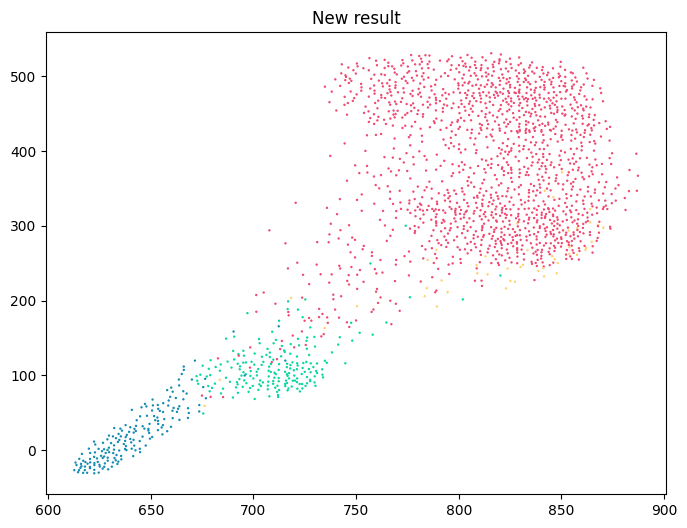

In [9]:
# Utilize ForceAtlas2 to visualize the KNN network in a two-dimensional coordinate system
num_force_iter = 1000
if num_force_iter > 0:
    positions = get_force_layout(links, Epca.shape[0], n_iter=num_force_iter,
        edgeWeightInfluence=1, barnesHutTheta=2, scalingRatio=1, gravity=0.05,
        jitterTolerance=1, verbose=False)
    positions = positions / 5.0
    positions = positions - np.min(positions, axis = 0) - np.ptp(positions, axis = 0) / 2.0
    positions[:,0] = positions[:,0]  + 750
    positions[:,1] = positions[:,1]  + 250

df_position = np.hstack((np.arange(positions.shape[0])[:,None], positions))
df_coor = pd.DataFrame(df_position[:, 1:3], index=df_anno.index, columns=['x', 'y'])
df_coor.to_csv('pbmc_spring_coor.csv')

# plot
dic_anno = dict(zip(df_anno.index, df_anno['celltypist_cell_label_fine']))
df_coor.index = df_harmony.index
df_coor['celltypist_cell_label_fine'] = df_anno.index.map(dic_anno)

# the red dots represent the GCB cells while the yellow dots represent the naiveB cells
dic_color = {'Tcm/Naive helper T cells': '#EF476F','MAIT cells': '#06D6A0',
                'NK cells': '#118AB2','Regulatory T cells': '#FFD166'}
df_coor['color'] = df_coor['celltypist_cell_label_fine'].map(dic_color)
plt.figure(figsize=(8, 6))
plt.scatter(x=df_coor['x'], y=df_coor['y'], c=df_coor['color'], s=0.5)
plt.title('New result')
plt.show()